In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import pickle as pkl

import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh

from scipy.spatial.distance import pdist
from scipy.spatial.distance import cdist

## Calculate distances for balanced clusters

In [254]:
nodes_in_cluster       = 1000

# range between 0 and 10
nodes_generation_lim   = 150

# range between 0 and 3
between_generation_lim = 30

max_weight = 20

# percent of nodes that are dummies

p_s = [0.0, 0.99, 0.95, 0.90, 0.00, 0.00, 0.00]
p_d = [0.0, 0.99, 0.95, 0.90, 0.00, 0.00, 0.00]
p_b = [0.0, 0.00, 0.00, 0.00, 0.99, 0.95, 0.90]

p_between  = []
p_cluster1 = []
p_cluster2 = []

no_runs = 10
# run it multiple times and average the data
for _r in range(0, no_runs):
    print("Run no. {}".format(_r))

    k_between  = []
    k_cluster1 = []
    k_cluster2 = []
    # in cluster nodes
    # cluster 1
    src = []
    dst = []   
    for i in range(0, nodes_in_cluster):
        entries = np.random.choice(np.array(range(0, nodes_generation_lim + 1)), size = 1)[0]
        dsts    = np.random.choice(np.delete(np.array(range(0, nodes_in_cluster)), i, None), size = entries, replace = False)
        for d in dsts:
            src.append(i)
            dst.append(d)

    # get proc_src% of the nodes as actual nodes, the rest are dummies
    df_source           = pd.DataFrame(list(zip(src, dst)), columns = ["src", "dst"])
    df_source['weight'] = 1

    swap_cond = df_source.src > df_source.dst
    df_source.loc[swap_cond, ['src', 'dst']] = df_source.loc[swap_cond, ['dst', 'src']].values
    df_source = df_source.groupby([df_source['src'], df_source['dst']], as_index = False).aggregate('sum')
    df_source['weight'] = 0.1

    for _i in df_source.index:
        df_source.loc[_i, 'weight'] += np.random.choice(np.array(range(1, max_weight + 1)), size = 1)[0]

    # cluster 2
    src = []
    dst = []
    for j in range(nodes_in_cluster, nodes_in_cluster * 2):
        entries = np.random.choice(np.array(range(0, nodes_generation_lim + 1)), size = 1)[0]
        dsts    = np.random.choice(np.delete(np.array(range(nodes_in_cluster, nodes_in_cluster * 2)), j - nodes_in_cluster, None), size = entries, replace = False)
        for d in dsts:
            src.append(j)
            dst.append(d)

    df_destination = pd.DataFrame(list(zip(src, dst)), columns = ["src", "dst"])
    df_destination['weight'] = 1

    swap_cond = df_destination.src > df_destination.dst
    df_destination.loc[swap_cond, ['src', 'dst']] = df_destination.loc[swap_cond, ['dst', 'src']].values
    df_destination = df_destination.groupby([df_destination['src'], df_destination['dst']], as_index = False).aggregate('sum')
    df_destination['weight'] = 0.1

    for _i in df_destination.index:
        df_destination.loc[_i, 'weight'] += np.random.choice(np.array(range(1, max_weight + 1)), size = 1)[0]    

    # in between cluster edges
    src = []
    dst = []

    src_nodes = list(np.unique(df_source['src']))
    src_nodes.extend(list(np.unique(df_source['dst'])))

    dst_nodes = list(np.unique(df_destination['src']))
    dst_nodes.extend(list(np.unique(df_destination['dst'])))

    for _src in np.unique(src_nodes):

        entries = np.random.choice(np.array(range(0, between_generation_lim + 1)), size = 1)[0]
        dsts    = np.random.choice(np.unique(dst_nodes), size = entries, replace = False)
        for d in dsts:
            src.append(_src)
            dst.append(d)

    df_b = pd.DataFrame(list(zip(src, dst)), columns = ["src", "dst"])
    df_b['weight'] = 1

    swap_cond = df_b.src > df_b.dst
    df_b.loc[swap_cond, ['src', 'dst']] = df_b.loc[swap_cond, ['dst', 'src']].values
    df_b = df_b.groupby([df_b['src'], df_b['dst']], as_index = False).aggregate('sum')
    df_b['weight'] = 0.1

    for _i in df_b.index:
        df_b.loc[_i, 'weight'] += np.random.choice(np.array(range(1, max_weight + 1)), size = 1)[0]  

    # for each 
    for proc_src, proc_dst, proc_b in zip(p_s, p_d, p_b):

        # get the base of the clusters
        b_source = df_source.copy()
        b_dest   = df_destination.copy()
        b_b      = df_b.copy()
        
        idx = np.random.choice(np.array(range(0, len(b_source))), size = int(proc_src * len(b_source)), replace = False)
        for index in idx:
            b_source.loc[index, 'weight'] = 0.1

        idx = np.random.choice(np.array(range(0, len(b_dest))), size = int(proc_dst * len(b_dest)), replace = False)
        for index in idx:
            b_dest.loc[index, 'weight'] = 0.1

        idx = np.random.choice(np.array(range(0, len(b_b))), size = int(proc_b * len(b_b)), replace = False)
        for index in idx:
            b_b.loc[index, 'weight'] = 0.1


        # merge the dataframes and compute the eigenvectors
        df        = pd.concat([b_source, b_dest, b_b])
        graph     = nx.from_pandas_edgelist(df, "src", "dst", edge_attr = True)
        laplacian = nx.normalized_laplacian_matrix(graph, weight = 'weight')

        try:
            eig_vals, eig_vecs = eigsh(laplacian, k = 3, which = "SM")
        except:
            print('tolerance required')
            eig_vals, eig_vecs = eigsh(laplacian, k = 3, which = "SM", tol = 1e-16)

        # get the cluster indexes
        v = []
        cluster1 = []
        cluster2 = []
        idx = 0
        for node in graph.nodes():
            if node < nodes_in_cluster: 
                v.append('r')
                cluster1.append(idx)
            else:
                v.append('b')
                cluster2.append(idx)

            idx += 1

        # get the distances
        normed = eig_vecs[:, 1:3]
        for iter in range(0, len(normed)):
            n = np.linalg.norm(normed[iter], ord = 2)
            for k_column in range(0, 2):
                normed[iter][k_column] = normed[iter][k_column] / n

        xa = []
        xb = []
        for iter in range(0, 2):
            xa.append(normed[cluster1, iter].mean())
            xb.append(normed[cluster2, iter].mean())

        xa = np.array(xa).reshape(1, 2)
        xb = np.array(xb).reshape(1, 2)
        k_between.append(cdist(xa, xb)[0][0])
        k_cluster1.append(pdist(normed[cluster1, :]).mean())
        k_cluster2.append(pdist(normed[cluster2, :]).mean())
        
    p_between.append(k_between)
    p_cluster1.append(k_cluster1)
    p_cluster2.append(k_cluster2)

Run no. 0
Run no. 1
Run no. 2
Run no. 3
Run no. 4
Run no. 5
Run no. 6
Run no. 7
Run no. 8
Run no. 9


In [258]:
p_between  = np.array(p_between)
p_cluster1 = np.array(p_cluster1)
p_cluster2 = np.array(p_cluster2)

avg_b  = []
avg_c1 = []
avg_c2 = []
for i in range(0, len(p_between[0])):
    avg_b.append(p_between[:, i].mean())
    avg_c1.append(p_cluster1[:, i].mean())
    avg_c2.append(p_cluster2[:, i].mean())

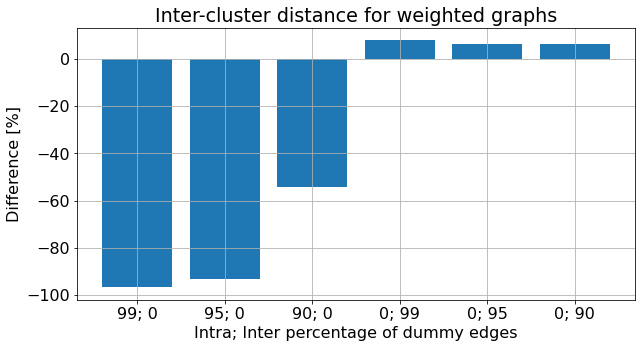

In [6]:
plt.figure(figsize = (10, 5))
plt.rcParams.update({'font.size': 16})
plt.bar(x = range(0, 6), height = 100 * (avg_b[1:] / avg_b[0] - 1))
plt.xticks(ticks = range(0, 6), labels = ['99; 0', '95; 0', '90; 0', '0; 99', '0; 95', '0; 90'])
plt.ylabel("Difference [%]")
plt.xlabel("Intra; Inter percentage of dummy edges")
plt.title("Inter-cluster distance for weighted graphs")
plt.grid()

plt.savefig("../plots/test_graphs/weighted/intercluster_distance.png", bbox_inches = 'tight')

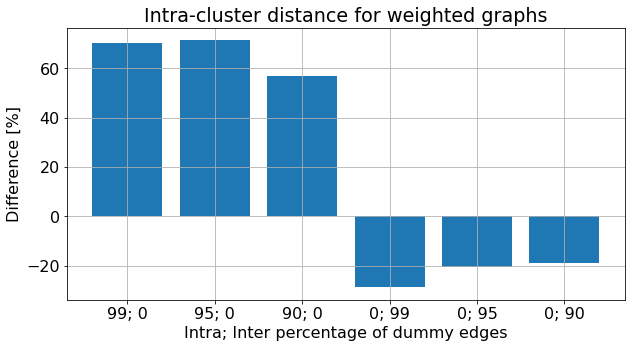

In [5]:
plt.figure(figsize = (10, 5))
plt.rcParams.update({'font.size': 16})
plt.bar(x = range(0, 6), height = 100 * ((avg_c1[1:] + np.array(avg_c2[1:]))/ (avg_c1[0]  + avg_c2[0])- 1))
plt.xticks(ticks = range(0, 6), labels = ['99; 0', '95; 0', '90; 0', '0; 99', '0; 95', '0; 90'])
plt.ylabel("Difference [%]")
plt.xlabel("Intra; Inter percentage of dummy edges")
plt.title("Intra-cluster distance for weighted graphs")
plt.grid()

plt.savefig("../plots/test_graphs/weighted/intracluster_distance.png", bbox_inches = 'tight')

## Pickle the results

In [294]:
with open("../pickle/test_weighted_eigenmaps.pkl", "wb") as file:
    pkl.dump([avg_b, avg_c1, avg_c2], file)